<a href="https://colab.research.google.com/github/Nicolasalan/td3/blob/main/TD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup**

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Add script in browser console: `inspect` => `console` => add script.

```javascript
function ConnectButton(){
    console.log("Conectado");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
```

## **Install**

In [ ]:
!sudo apt-get install swig

!pip install gymnasium
!pip install gymnasium[box2d]

!pip install torch
!pip install matplotlib
!pip install numpy
!pip install wandb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,296 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline


## **Import**

In [ ]:
try:
    import torch
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    print(f"torch version: {torch.__version__}")
except:
    print(f"[INFO] torch versions not as required, installing nightly versions.")

torch version: 2.2.1+cu121


In [ ]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.


In [ ]:
# Check available GPU memory and total GPU memory
try:
  total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
  print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
  print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")
except:
  print("Please check that you have an NVIDIA GPU and installed a driver from ")

Please check that you have an NVIDIA GPU and installed a driver from 


In [ ]:
# Set batch size depending on amount of GPU memory
try:
  total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
  if total_free_gpu_memory_gb >= 16:
    BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE}")
  else:
    BATCH_SIZE = 32
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE}")
except:
  BATCH_SIZE = 32

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 100        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
UPDATE_EVERY_STEP = 2   # how often to update the target and actor networks

## **Replay**

In [ ]:
from collections import namedtuple, deque
from typing import Tuple
import random
import numpy as np
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:

    def __init__(self, buffer_size: int, batch_size: int):

        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state: np.ndarray, action: np.ndarray, reward: np.float64, next_state: np.float32, done: bool) -> None:
        """Add experiences to the buffer

        Params
        ======
            state (np.ndarray): agent states
            action (np.ndarray): agent action
            reward (np.float64): agent reward
            next_state (np.ndarray): agent next_state
        """

        assert isinstance(state, np.ndarray), "State is not of data structure (np.ndarray) in REPLAY BUFFER -> state: {}.".format(type(state))
        assert isinstance(action, np.ndarray), "Action is not of data structure (np.ndarray) in REPLAY BUFFER -> action: {}.".format(type(action))
        assert isinstance(next_state, np.ndarray), "Next State is not of data structure (np.ndarray) in REPLAY BUFFER -> next state: {}.".format(type(next_state))

        assert isinstance(state[0], np.float32), "State is not of type (np.float32) in REPLAY BUFFER -> state type: {}.".format(type(state))
        assert isinstance(action[0], np.float32), "Action is not of type (np.float32) in REPLAY BUFFER -> action type: {}.".format(type(action))
        assert isinstance(reward, (int, np.float64)), "Reward is not of type (np.float64 / int) in REPLAY BUFFER -> reward: {}.".format(type(reward))
        assert isinstance(next_state[0], np.float32), "Next State is not of type (np.float32) in REPLAY BUFFER -> next state type: {}.".format(type(next_state))
        assert isinstance(done, bool), "Done is not of type (bool) in REPLAY BUFFER -> done type: {}.".format(type(done))

        assert state.shape[0] == 24, "The size of the state is not (24) in REPLAY BUFFER -> state size: {}.".format(state.shape[0])
        assert action.shape[0] == 4, "The size of the action is not (4) in REPLAY BUFFER -> action size: {}.".format(state.shape[0])
        if isinstance(reward, np.float64):
          assert reward.size == 1, "The size of the reward is not (1) in REPLAY BUFFER -> reward size: {}.".format(reward.size)
        assert next_state.shape[0] == 24, "The size of the next_state is not (24) in REPLAY BUFFER -> next_state size: {}.".format(next_state.shape[0])

        assert state.ndim == 1, "The ndim of the state is not (1) in REPLAY BUFFER -> state ndim: {}.".format(state.ndim)
        assert action.ndim == 1, "The ndim of the action is not (1) in REPLAY BUFFER -> action ndim: {}.".format(state.ndim)
        if isinstance(reward, np.float64):
          assert reward.ndim == 0, "The ndim of the reward is not (0) in REPLAY BUFFER -> reward ndim: {}.".format(reward.ndim)
        assert next_state.ndim == 1, "The ndim of the next_state is not (1) in REPLAY BUFFER -> next_state ndim: {}.".format(next_state.ndim)

        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None])).int().to(device)

        assert isinstance(states, torch.Tensor), "State is not of type torch.Tensor in REPLAY BUFFER."
        assert isinstance(actions, torch.Tensor), "Actions is not of type torch.Tensor in REPLAY BUFFER."
        assert isinstance(rewards, torch.Tensor), "Rewards is not of type torch.Tensor in REPLAY BUFFER."
        assert isinstance(next_states, torch.Tensor), "Next states is not of type torch.Tensor in REPLAY BUFFER."
        assert isinstance(dones, torch.Tensor), "Dones is not of type torch.Tensor in REPLAY BUFFER."

        assert states.dtype == torch.float32, "The (state) tensor elements are not of type torch.float32 in the REPLAY BUFFER -> {}.".format(states.dtype)
        assert actions.dtype == torch.float32,"The (actions) tensor elements are not of type torch.float32 in the REPLAY BUFFER -> {}.".format(actions.dtype)
        assert rewards.dtype == torch.float32, "The (rewards) tensor elements are not of type torch.float32 in the REPLAY BUFFER -> {}.".format(rewards.dtype)
        assert next_states.dtype == torch.float32, "The (next_states) tensor elements are not of type torch.float32 in the REPLAY BUFFER -> {}.".format(next_states.dtype)
        assert dones.dtype == torch.int, "The (dones) tensor elements are not of type torch.float32 in the REPLAY BUFFER -> {}.".format(dones.dtype)

        # TODO
        # assert all(tensor.device.type == DEVICE for tensor in [states, actions, rewards, next_states, dones]), "Each tensor must be on the same device in REPLAY BUFFER"

        return (
            states, actions, rewards, next_states, dones
        )

    def __len__(self) -> None:
        """Return the current size of internal memory."""
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Model**

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):

    def __init__(self, state_size: int, action_size: int, max_action: float, l1=400, l2=300):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_size, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(l2, action_size)
        self.reset_parameters()

        self.max_action = max_action

    def reset_parameters(self):
        self.l1.weight.data.uniform_(*hidden_init(self.l1))
        self.l2.weight.data.uniform_(*hidden_init(self.l2))
        self.l3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state) -> torch.Tensor:


        assert isinstance(state, torch.Tensor), "State is not of type torch.Tensor in ACTOR."
        assert state.dtype == torch.float32, "Tensor elements are not of type torch.float32 in ACTOR."
        assert state.shape[0] <= 24 or state.shape[0] >= BATCH_SIZE, "The tensor shape is not torch.Size([24]) in ACTOR."
        assert str(state.device.type) == str(DEVICE), "The state must be on the same device in ACTOR."

        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        action = self.max_action * torch.tanh(self.l3(x))
        return action


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, l1=400, l2=300):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(action_dim, l2)
        self.l4 = nn.Linear(l2, 1)
        self.reset_parameters_q1()

        self.l5 = nn.Linear(state_dim + action_dim, l1)
        self.l6 = nn.Linear(l1, l2)
        self.l7 = nn.Linear(action_dim, l2)
        self.l8 = nn.Linear(l2, 1)
        self.reset_parameters_q2()

    def reset_parameters_q1(self):
        self.l1.weight.data.uniform_(*hidden_init(self.l1))
        self.l2.weight.data.uniform_(*hidden_init(self.l2))
        self.l3.weight.data.uniform_(*hidden_init(self.l3))
        self.l4.weight.data.uniform_(-3e-3, 3e-3)

    def reset_parameters_q2(self):
        self.l5.weight.data.uniform_(*hidden_init(self.l5))
        self.l6.weight.data.uniform_(*hidden_init(self.l6))
        self.l7.weight.data.uniform_(*hidden_init(self.l7))
        self.l8.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action) -> Tuple[torch.Tensor, torch.Tensor]:
        assert isinstance(state, torch.Tensor), "State is not of type torch.Tensor in CRITIC."
        assert state.dtype == torch.float32, "Tensor elements are not of type torch.float32 in CRITIC."
        assert state.shape[0] == BATCH_SIZE, "The tensor shape is not torch.Size([100]) in CRITIC."
        assert str(state.device.type) == str(DEVICE), "The state must be on the same device  in CRITIC."

        assert isinstance(action, torch.Tensor), "Action is not of type torch.Tensor in CRITIC."
        assert action.dtype == torch.float32, "Tensor elements are not of type torch.float32 in CRITIC."
        assert action.shape[0] == BATCH_SIZE, "The action shape is not torch.Size([100]) in CRITIC."
        assert str(action.device.type) == str(DEVICE), "The action must be on the same device  in CRITIC."

        s = torch.cat([state, action], dim=1)

        s1 = F.relu(self.l1(s))
        s1 = F.relu(self.l2(s1))
        a1 = F.relu(self.l3(action))
        s1 = s1 + a1
        q1 = self.l4(s1)

        s2 = F.relu(self.l5(s))
        s2 = F.relu(self.l6(s2))
        a2 = F.relu(self.l7(action))
        s2 = s2 + a2
        q2 = self.l8(s2)
        return (q1, q2)

    def Q1(self, state, action) -> torch.Tensor:
        assert isinstance(state, torch.Tensor), "State is not of type torch.Tensor in CRITIC."
        assert state.dtype == torch.float32, "Tensor elements are not of type torch.float32 in CRITIC."
        assert state.shape[0] == BATCH_SIZE, "The tensor shape is not torch.Size([100]) in CRITIC."
        assert str(state.device.type) == str(DEVICE), "The state must be on the same device in CRITIC."

        assert isinstance(action, torch.Tensor), "Action is not of type torch.Tensor in CRITIC."
        assert action.dtype == torch.float32, "Tensor elements are not of type torch.float32 in CRITIC."
        assert action.shape[0] == BATCH_SIZE, "The action shape is not torch.Size([100]) in CRITIC."
        assert str(action.device.type) == str(DEVICE), "The action must be on the same device in CRITIC."

        s = torch.cat([state, action], dim=1)

        s1 = F.relu(self.l1(s))
        s1 = F.relu(self.l2(s1))
        a1 = F.relu(self.l3(action))
        s1 = s1 + a1
        q1 = self.l4(s1)
        return q1

## **Agent**

In [ ]:
from typing import Tuple

import torch
import copy
import numpy as np
import torch.optim as optim

from numpy import inf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TD3Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size: int, action_size: int, max_action: int, min_action: int, noise=0.2, noise_std=0.1, noise_clip=0.5, continue_training=False):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            max_action (ndarray): the maximum valid value for each action vector
            min_action (ndarray): the minimum valid value for each action vector
            noise (float): the range to generate random noise while learning
            noise_std (float): the range to generate random noise while performing action
            noise_clip (float): to clip random noise into this range
        """
        self.state_size = state_size
        self.action_size = action_size
        self.max_action = max_action
        self.min_action = min_action
        self.noise = noise
        self.noise_std = noise_std
        self.noise_clip = noise_clip

        # Set the device globally
        torch.set_default_device(device)

        if continue_training:

          # Transfer Learning
          self.actor = Actor(state_size, action_size, float(max_action[0])).to(device)
          self.actor.load_state_dict(torch.load('/content/checkpoint_actor_300.pth'))
          self.actor_target = Actor(state_size, action_size, float(max_action[0])).to(device)
          self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
          self.actor_optimizer.load_state_dict(torch.load('/content/checkpoint_actor_optimizer_300.pth'))

          self.critic = Critic(state_size, action_size).to(device)
          self.critic.load_state_dict(torch.load('/content/checkpoint_critic_300.pth'))
          self.critic_target = Critic(state_size, action_size).to(device)
          self.critic_target.load_state_dict(self.critic.state_dict())
          self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
          self.critic_optimizer.load_state_dict(torch.load('/content/checkpoint_critic_optimizer_300.pth'))

        else:
          # Actor Network (w/ Target Network)
          self.actor = Actor(state_size, action_size, float(max_action[0])).to(device)
          self.actor_target = Actor(state_size, action_size, float(max_action[0])).to(device)
          self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)

          # Critic Network (w/ Target Network)
          self.critic = Critic(state_size, action_size).to(device)
          self.critic_target = Critic(state_size, action_size).to(device)
          self.critic_target.load_state_dict(self.critic.state_dict())
          self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

    def step(self, state, action, reward, next_state, done) -> None:
        """Save experience in replay memory"""
        self.memory.add(state, action, reward, next_state, done)

    def predict(self, states) -> np.ndarray:
        """Returns actions for given state as per current policy."""

        assert isinstance(states, np.ndarray), "States is not of data structure (np.ndarray) in PREDICT -> states: {}.".format(type(states))
        assert isinstance(states[0], np.float32), "States is not of type (np.float32) in PREDICT -> states type: {}.".format(type(states))
        assert states.shape[0] == 24, "The size of the states is not (24) in PREDICT -> states size: {}.".format(states.shape[0])
        assert states.ndim == 1, "The ndim of the states is not (1) in PREDICT -> states ndim: {}.".format(states.ndim)

        state = torch.from_numpy(states).float().to(device)

        self.actor.eval()
        with torch.no_grad():
          action = self.actor(state).cpu().data.numpy()

        self.actor.train()

        action = action.clip(self.min_action[0], self.max_action[0])

        assert len(action) == self.action_size, "The action size is different from the defined size in PREDICT."
        assert isinstance(action[0], np.float32), "Action is not of type (np.float32) in PREDICT -> action type: {}.".format(type(action))

        return action

    def learn(self, n_iteraion: int, gamma=GAMMA) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """ Update policy and value parameters using given batch of experience tuples.

        Params
        ======
            n_iteraion (int): the number of iterations to train network
            gamma (float): discount factor
        """

        if len(self.memory) > BATCH_SIZE:
            average_Q = 0
            max_Q = -inf
            average_critic_loss = 0
            average_actor_loss = 0

            for i in range(n_iteraion):
                state, action, reward, next_state, done = self.memory.sample()

                action_ = action.cpu().numpy()

                # ---------------------------- update critic ---------------------------- #
                # Get predicted next-state actions and Q values from target models

                with torch.no_grad():

                    # Generate a random noise
                    noise = torch.FloatTensor(action_).data.normal_(0, self.noise).to(device)
                    noise = noise.clamp(-self.noise_clip, self.noise_clip)
                    actions_next = (self.actor_target(next_state) + noise).clamp(self.min_action[0].astype(float), self.max_action[0].astype(float))

                    Q1_targets_next, Q2_targets_next = self.critic_target(next_state, actions_next)

                    Q_targets_next = torch.min(Q1_targets_next, Q2_targets_next)

                    average_Q += torch.mean(Q_targets_next)
                    max_Q = max(max_Q, torch.max(Q_targets_next))

                    # Compute Q targets for current states (y_i)
                    Q_targets = reward + (gamma * Q_targets_next * (1 - done)).detach()

                # Compute critic loss
                Q1_expected, Q2_expected = self.critic(state, action)
                critic_loss = F.mse_loss(Q1_expected, Q_targets) + F.mse_loss(Q2_expected, Q_targets)

                # Minimize the loss
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                if i % UPDATE_EVERY_STEP == 0:
                    # ---------------------------- update actor ---------------------------- #
                    # Compute actor loss
                    actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

                    # Minimize the loss
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()

                    # ----------------------- update target networks ----------------------- #
                    self.soft_update(self.critic, self.critic_target, TAU)
                    self.soft_update(self.actor, self.actor_target, TAU)

                average_critic_loss += critic_loss
                average_actor_loss += actor_loss

            loss_critic = average_critic_loss / n_iteraion
            loss_actor = average_actor_loss / n_iteraion
            average_policy = average_Q / n_iteraion
            max_policy = max_Q

            return (loss_critic, loss_actor, average_policy, max_policy)

    def soft_update(self, local_model, target_model, tau) -> None:
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save(self, filename, version) -> None:
          """ Save the model """
          torch.save(self.critic.state_dict(), filename + "_critic_" + version + ".pth")
          torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer_" + version + ".pth")

          torch.save(self.actor.state_dict(), filename + "_actor_" + version + ".pth")
          torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer_" + version + ".pth")

    def load(self, filename) -> None:
          """ Load the model """
          self.critic.load_state_dict(torch.load(filename))
          self.critic_optimizer.load_state_dict(torch.load(filename))
          self.critic_target = copy.deepcopy(self.critic)

          self.actor.load_state_dict(torch.load(filename))
          self.actor_optimizer.load_state_dict(torch.load(filename))
          self.actor_target = copy.deepcopy(self.actor)


## **Wrapper**

In [ ]:
import gym
import wandb
from typing import Union
from gym import spaces
from gym.spaces import Box

class CustomWrapper(gym.Wrapper):

    def __init__(
        self,
        env: gym.Env,
        min_action: Union[float, int, np.ndarray],
        max_action: Union[float, int, np.ndarray],
    ):
        """Initializes the :class:`RescaleAction` wrapper.
        Args:
            env (Env): The environment to apply the wrapper
            min_action (float, int or np.ndarray): The min values for each action. This may be a numpy array or a scalar.
            max_action (float, int or np.ndarray): The max values for each action. This may be a numpy array or a scalar.
        """
        assert isinstance(
            env.action_space, spaces.Box
        ), f"expected Box action space, got {type(env.action_space)}"
        assert np.less_equal(min_action, max_action).all(), (min_action, max_action)

        super().__init__(env)
        self.min_action = (
            np.zeros(env.action_space.shape, dtype=env.action_space.dtype) + min_action
        )
        self.max_action = (
            np.zeros(env.action_space.shape, dtype=env.action_space.dtype) + max_action
        )
        self.action_space = spaces.Box(
            low=min_action,
            high=max_action,
            shape=env.action_space.shape,
            dtype=env.action_space.dtype,
        )
        low = self.observation_space.low[:24]
        high = self.observation_space.high[:24]
        self.observation_space = Box(low, high, dtype=np.float32)

    def step(self, action):
        obs, reward, terminated, info = self.env.step(action)
        obs = obs[:24]
        return obs, reward, terminated, info

    def reset(self):
        obs = self.env.reset()
        obs = obs[:24]
        return obs

    def action(self, action):
        """Rescales the action affinely from  [:attr:`min_action`, :attr:`max_action`] to the action space of the base environment, :attr:`env`.
        Args:
            action: The action to rescale
        Returns:
            The rescaled action
        """
        assert np.all(np.greater_equal(action, self.min_action)), (
            action,
            self.min_action,
        )
        assert np.all(np.less_equal(action, self.max_action)), (action, self.max_action)
        low = self.env.action_space.low
        high = self.env.action_space.high
        action = low + (high - low) * (
            (action - self.min_action) / (self.max_action - self.min_action)
        )
        action = np.clip(action, low, high)
        return action

    def seed(self, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)

gym.logger.set_level(40)
env = CustomWrapper(gym.make("BipedalWalker-v3"),  min_action = -1.0,  max_action = 1.0)
env.seed(0)

agent = TD3Agent(state_size=env.observation_space.shape[0], \
                 action_size=env.action_space.shape[0], \
                 max_action=env.action_space.high, \
                 min_action=env.action_space.low, continue_training=False)


## **Train**

In [ ]:
wandb.init(project="td3") # fb372890f5180a16a9cd2df5b9558e55493cd16c

/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import time

def td3(n_episodes=2000, max_t=2000):
    scores_deque = deque(maxlen=100)
    times_deque = deque(maxlen=100)
    scores = []
    solved = False
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        start_time = time.time()
        for t in range(max_t):
            action = agent.predict(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done or t==(max_t-1):
                critic_loss, actor_loss, q, max = agent.learn(t)
                break

        duration = time.time() - start_time

        scores_deque.append(score)
        times_deque.append(duration)
        scores.append(score)
        mean_score = np.mean(scores_deque)
        mean_times = np.mean(times_deque)

        #wandb.log({'Score': mean_score, 'Critic loss': critic_loss, 'Actor loss': actor_loss, 'Average Q': q, 'Max. Q': max, "Duration ": mean_times}, step=i_episode)

        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
        if i_episode % 500 == 0:
            agent.save("checkpoint", str(i_episode))
        if mean_score >= 300 and solved == False:
            print('\rSolved at Episode {} !\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            agent.save("checkpoint")
            solved = True

    return scores

scores = td3()

Episode 8	Average Score: -101.28	Score: -102.52

KeyboardInterrupt: 

## **Result**

In [ ]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Score: 263.1796404668868


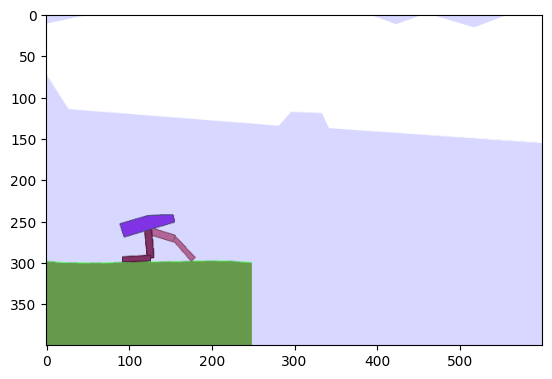

In [ ]:
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

agent.actor.load_state_dict(torch.load('/content/checkpoint_actor_300.pth'))
agent.critic.load_state_dict(torch.load('/content/checkpoint_critic_300.pth'))
agent.actor_optimizer.load_state_dict(torch.load('/content/checkpoint_actor_optimizer_300.pth'))
agent.critic_optimizer.load_state_dict(torch.load('/content/checkpoint_critic_optimizer_300.pth'))

env = gym.make('BipedalWalker-v3')
state = env.reset()
score = 0
img = plt.imshow(env.render('rgb_array'))
while True:
    img.set_data(env.render('rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = agent.predict(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    score += reward
    if np.any(done):
        break

print("Score: {}".format(score))

## **Test**

In [ ]:
class TestModel(unittest.TestCase):

    def setUp(self):
        self.env = gym.make("BipedalWalker-v3")

        # param model and buffer
        self.batch_size = 100
        self.buffer_size = int(1e5)
        self.random_seed = 0
        self.error = 0

        # size action / state
        self.action_size = self.env.action_space.shape[0]
        self.state_size = self.env.observation_space.shape[0]

        # min / max action
        self.min_action = self.env.action_space.low
        self.max_action = self.env.action_space.high

        # min / max state
        self.min_state = 0
        self.max_state = 1

        # min / max reward
        self.min_reward = -300
        self.max_reward = 300

        self.model = TD3Agent(state_size=self.state_size, action_size=self.action_size, \
                         max_action=self.max_action, min_action=self.min_action, random_seed=self.random_seed)

        self.memory = ReplayBufferPer(self.buffer_size)

        # param number tests
        self.num_attempts = 150

    def _randomStates(self):
        states = np.array([random.uniform(self.min_state, self.max_state) for _ in range(24)], dtype=np.float32)
        return states

    def _randomAction(self):
        action = np.random.uniform(self.min_action, self.max_action, self.action_size)
        return action

    def _randomDone(self):
        done = random.choice([True, False])
        return done

    def _randomReward(self):
        reward = random.randint(self.min_reward, self.max_reward)
        return reward

    def test_predict_act(self):
        """ Teste para verificar se o estado de saida da rede contem os valores minimos e maximos de ação que o ambiente exigi

            Input: numpy.ndarray [24]
            output: numpy.ndarray [4]

        """

        for _ in range(self.num_attempts):
            states = self._randomStates()
            action = self.model.predict(states)
            is_valid = (isinstance(action, np.ndarray) and np.all(action >= self.min_action) and np.all(action <= self.max_action))

            if not is_valid:
                self.fail("Teste falhou na tentativa {}".format(_ + 1))

    def test_buffer_type(self):
        while True:
          next_state, reward, done, action, state = self._randomStates(), self._randomReward(), self._randomDone(), self._randomAction(), self._randomStates()

          self.memory.add((state, action, reward, next_state, done), reward)

          if len(self.memory) > self.batch_size:
              break


        (states, actions, rewards, next_states, dones), idxs, is_weights = self.memory.sample(self.batch_size)

        self.assertIsInstance(states, torch.Tensor)
        self.assertIsInstance(actions, torch.Tensor)
        self.assertIsInstance(rewards, torch.Tensor)
        self.assertIsInstance(next_states, torch.Tensor)
        self.assertIsInstance(dones, torch.Tensor)

    def test_buffer_size(self):
        while True:
          next_state, reward, done, action, state = self._randomStates(), self._randomReward(), self._randomDone(), self._randomAction(), self._randomStates()
          self.memory.add((state, action, reward, next_state, done), reward)

          if len(self.memory) > self.batch_size:
            break

        (states, actions, rewards, next_states, dones), idxs, is_weights = self.memory.sample(self.batch_size)

        expected_batch_size = self.batch_size
        self.assertEqual(states.size(0), expected_batch_size)
        self.assertEqual(actions.size(0), expected_batch_size)
        self.assertEqual(rewards.size(0), expected_batch_size)
        self.assertEqual(next_states.size(0), expected_batch_size)
        self.assertEqual(dones.size(0), expected_batch_size)

    def test_buffer_range(self):
        while True:
          next_state, reward, done, action, state = self._randomStates(), self._randomReward(), self._randomDone(), self._randomAction(), self._randomStates()
          self.memory.add((state, action, reward, next_state, done), reward)

          if len(self.memory) > self.batch_size:
            break

        (states, actions, rewards, next_states, dones), idxs, weights = self.memory.sample(self.batch_size)

        self.assertTrue(np.all(states[1].cpu().data.numpy() >= self.min_state) and np.all(states[1].cpu().data.numpy() <= self.max_state))
        self.assertTrue(np.all(actions[1].cpu().data.numpy() >= self.min_action) and np.all(actions[1].cpu().data.numpy() <= self.max_action))
        self.assertTrue(np.all(rewards[1].cpu().data.numpy() >= self.min_reward) and np.all(rewards[1].cpu().data.numpy() <= self.max_reward))
        self.assertTrue(np.all(next_states[1].cpu().data.numpy() >= self.min_state) and np.all(next_states[1].cpu().data.numpy() <= self.max_state))
        self.assertTrue(np.all(dones.cpu().data.numpy() >= 0.) and np.all(dones.cpu().data.numpy() <= 1.))

if __name__ == "__main__":
    unittest.main(argv=['first-arg-is-ignored'], exit=False)